# Time Series Project

#### Meng Lin, Hannah Lyon, Kyrill Rekun, Qingyi Sun

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import arma_order_select_ic
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.impute import SimpleImputer

In [66]:
df = pd.read_csv('zillow-california.csv', parse_dates = ['Date'])
df.columns = ['Date','Median_Sold_Price','Median_Mortgage','Unemployment','Median_Rental_Price']
df.head()

,Date,Median_Sold_Price,Median_Mortgage,Unemployment,Median_Rental_Price
0,2004-01-31,326752.55,5.02,7.9,NaN
1,2004-02-29,329501.50,4.94,7.8,NaN
2,2004-03-31,340125.45,4.74,7.8,NaN
3,2004-04-30,355329.50,5.16,7.5,NaN
4,2004-05-31,367818.15,5.64,7.3,NaN


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 5 columns):
Date                   164 non-null datetime64[ns]
Median_Sold_Price      144 non-null float64
Median_Mortgage        164 non-null float64
Unemployment           164 non-null float64
Median_Rental_Price    92 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 6.5 KB


In [71]:
x = df['Median_Sold_Price'].loc[(df['Median_Sold_Price'].notna())]
x = pd.DataFrame(x)

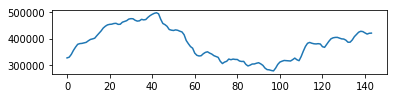

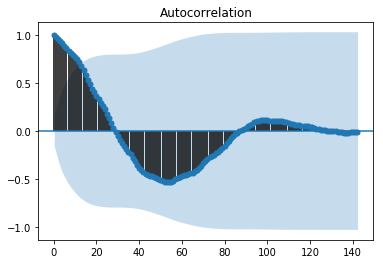

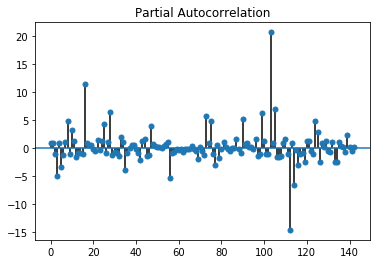

In [74]:
# draw plots
plt.subplot(3,1,1)
plt.plot(x) 
plt.show()
plot_acf(x, lags = 142) 
plt.show()
plot_pacf(x, lags = 142) 
plt.show()

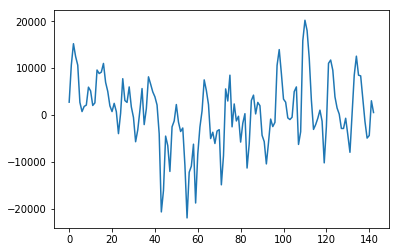

In [97]:
# try one time differencing
li_x = x.values
d1 = list()
for i in range(1, len(li_x)):
    value = li_x[i] - li_x[i - 1]
    d1.append(float(value))
    
plt.plot(d1) 


In [100]:
# ADF TEST for d = 1

from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(d1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.687305
p-value                          0.437665
#Lags Used                      12.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


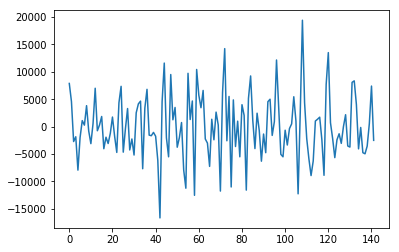

In [101]:
d2 = list()
for i in range(1, len(d1)):
    value = d1[i] - d1[i - 1]
    d2.append(value)

plt.plot(d2)

In [102]:
# ADF for d = 2
adf_test(d2)

Results of Dickey-Fuller Test:
Test Statistic                  -4.918846
p-value                          0.000032
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [103]:
model = pm.auto_arima(x, start_p=1, start_q=1,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=1,              
                      d=2,           
                      seasonal=True,   
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=2859.631, BIC=2871.454, Fit time=0.152 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=2864.973, BIC=2870.885, Fit time=0.007 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=2865.434, BIC=2874.301, Fit time=0.015 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=2865.376, BIC=2874.243, Fit time=0.019 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=2864.416, BIC=2879.196, Fit time=0.100 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=2861.222, BIC=2876.001, Fit time=0.218 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=2863.397, BIC=2881.132, Fit time=0.258 seconds
Total fit time: 0.772 seconds
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(1, 2, 1)   Log Likelihood         

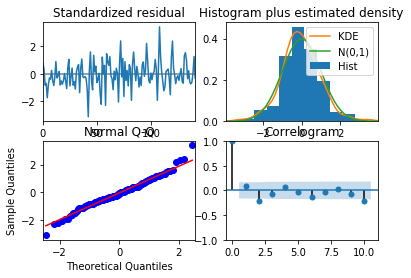

In [104]:
model.plot_diagnostics()
plt.show()

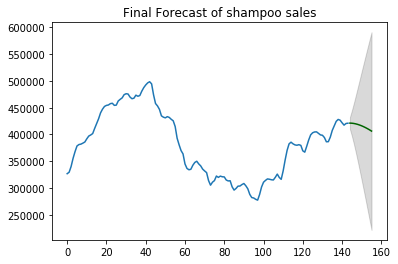

In [105]:
n_periods = 12
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(x), len(x)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(x)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of shampoo sales")
plt.show()

In [106]:
model.predict(n_periods=n_periods)

array([421162.0385755 , 420980.89483142, 420494.34547242, 419734.25981384,
       418727.52355859, 417496.81811714, 416061.2780601 , 414437.04576062,
       412637.73930387, 410674.84722633, 408558.0615272 , 406295.55860467])